# Setup

In [2]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
sns.set()
from tensorflow.keras import *
from tensorflow.keras.layers import *
from sklearn import preprocessing, model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

In [3]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)

#Load all data
data = pd.read_csv('data/updated_with_R.csv')

#Extract labels
y = data[['chord']]
tx = data.drop(columns=['Unnamed: 0'])

#Only keep the chords???
#tx = y

#Use one-hot encoding/dummy variabes for categorical values
y = pd.get_dummies(y)
tx = pd.get_dummies(tx)

#Replace Nans with zero, since x*nan = nan
tx = tx.replace(np.nan, 0)

#Standardize it? 
#tx = (tx-tx.mean())/tx.std()

#Split the data into training and test sets
#Since order is important, shuffle = False, but we should probably split on the moments or something similar
train_x, test_x, train_y, test_y = model_selection.train_test_split(tx, y, test_size = 0.1, shuffle = False)

# Data exploration

# Helper Functions

In [4]:
def disp_results(history_object):
    """
    Takes a history object and plots the evolution of the metrics as well as the final scores
    """
    history = history_object
    df = pd.DataFrame({'epochs': history.epoch,
                       'accuracy': history.history['acc'],
                       'validation_accuracy': history.history['val_acc'],
                       'loss': history.history['loss'], 
                       'val_loss': history.history['val_loss']})


    #Plot the the scores on the validation and training sets
    df.plot(x='epochs', y = ['validation_accuracy','accuracy'], figsize=[15,5])
    df.plot(x='epochs', y = ['val_loss','loss'], figsize=[15,5])

    a = history.history['acc'][-1]
    va= history.history['val_acc'][-1]
    l = history.history['loss'][-1]
    vl= history.history['val_loss'][-1]

    print("Final values\nacc\n{}\nvalacc\n{}\nloss\n{}\nvaloss\n{}\n".format(a, va, l, vl))
    
    print(history.model.summary())
    plt.show()

In [5]:
def generate_sequences(train_x, train_y, seq_length):
    """
    Input:
        train_x, train_y: the data we want to transform into sequences
        seq_length: the length of the sequences
    Return:
        lstm_x: a matrix where elements are on the form (sequence, sequence length, features)
        lstm_y: a matrix where elements are on the form (sequence, classes)
    Notes: 
        Does not generate sequences for the last (seq_length - 1) datapoints
        Takes quite a lot of computing with long sequence lengths.
        
        
    """
    #containers for the sequences we generate
    lstm_input = []
    lstm_output = []
    
    for i in range(0, train_x.shape[0] - (seq_length +1)):
        #Create a sequence
        in_data = train_x.iloc[i:seq_length + i].values
        lstm_input.append(in_data)
        
        #Select the chord that would have appeared after the sequence
        out_data = train_y.iloc[seq_length + i].values
        lstm_output.append(out_data) 

    #Convert to arrays
    lstm_x = np.array(lstm_input)
    lstm_y = np.array(lstm_output)
    
    return lstm_x, lstm_y

# Models

In [6]:
def lstm(lstm_x, lstm_y, optimizer, loss, metrics):
    """
    A LSTM, a neural network operating on sequences to predict next items in a sequence.
    Needs some data preprocessing to generate sequences
    """
    # Input layers
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(lstm_x.shape[1], lstm_x.shape[2]))) 
    model.add(Dropout(0.3))
    model.add(LSTM(512, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(256))
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Activation('softmax')) 
    
    #Output layers
    model.add(Dense(lstm_y.shape[1], activation='softmax'))

    #Hyperparameters
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

In [7]:
def lstm2(lstm_x, lstm_y, optimizer, loss, metrics):
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(lstm_x.shape[1], lstm_x.shape[2])))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(128, return_sequences=True),input_shape=(lstm_x.shape[1],lstm_x.shape[2])))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(lstm_y.shape[1], activation='softmax'))

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    return model



In [8]:
def lstm3(lstm_x, lstm_y, optimizer, loss, metrics):
    #Based on https://arxiv.org/pdf/1712.01011.pdf
    model = Sequential()
    model.add(TimeDistributed(Dense(12), input_shape=(lstm_x.shape[1], lstm_x.shape[2])))
    model.add(Bidirectional(LSTM(128, return_sequences=True, activation='tanh')))
    model.add(Bidirectional(LSTM(128, return_sequences=False, activation='tanh')))
    model.add(Dense(lstm_y.shape[1], activation='softmax'))

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

In [ ]:
def lstm4(lstm_x, lstm_y, optimizer, loss, metrics):
    #Now with convolution
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(lstm_x.shape[1], lstm_x.shape[2])))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(128, return_sequences=True),input_shape=(lstm_x.shape[1],lstm_x.shape[2])))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(lstm_y.shape[1], activation='softmax'))

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    return model



# Train

## Setup

In [9]:
#Define model parameters
optimizer = optimizers.Adam()
loss = 'categorical_crossentropy'
metrics = ['accuracy']
callbacks_list = []  

In [ ]:
#Run this cell only if you want to checkpoint progress
checkpoint = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.hdf5',
    monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)

callbacks_list = [checkpoint]     

In [ ]:
#Run this cell to load saved weights
#model.load_weights('weights.10-4.13.hdf5')

## Fit

In [10]:
# Generate the sequences for the lstm
lstm_x, lstm_y = generate_sequences(train_x, train_y, 10)

#Generate model
model = lstm2(lstm_x, lstm_y, optimizer, loss, metrics)
    
#Train on it and save metrics at each epoch
history = model.fit(lstm_x,
                    lstm_y,
                    epochs = 100,
                    verbose = 1,
                    validation_split = 0.1, 
                    callbacks = callbacks_list)

h1 = history

Train on 22746 samples, validate on 2528 samples
Epoch 1/100
22746/22746 [==============================] - 175s 8ms/step - loss: 3.5930 - acc: 0.1084 - val_loss: 3.6007 - val_acc: 0.1021
Epoch 2/100
22746/22746 [==============================] - 171s 8ms/step - loss: 3.5470 - acc: 0.1182 - val_loss: 3.6369 - val_acc: 0.1021
Epoch 3/100
22746/22746 [==============================] - 153s 7ms/step - loss: 3.5397 - acc: 0.1185 - val_loss: 3.5981 - val_acc: 0.1021
Epoch 4/100
22746/22746 [==============================] - 154s 7ms/step - loss: 3.5302 - acc: 0.1173 - val_loss: 3.6081 - val_acc: 0.1017
Epoch 5/100
22746/22746 [==============================] - 154s 7ms/step - loss: 3.5240 - acc: 0.1187 - val_loss: 3.5859 - val_acc: 0.1274
Epoch 6/100
22746/22746 [==============================] - 154s 7ms/step - loss: 3.5012 - acc: 0.1245 - val_loss: 3.4704 - val_acc: 0.1570
Epoch 7/100
22746/22746 [==============================] - 154s 7ms/step - loss: 3.4199 - acc: 0.1385 - val_loss: 3.3

22746/22746 [==============================] - 153s 7ms/step - loss: 2.8241 - acc: 0.2571 - val_loss: 3.1027 - val_acc: 0.2199
Epoch 60/100
22746/22746 [==============================] - 153s 7ms/step - loss: 2.8246 - acc: 0.2585 - val_loss: 3.0744 - val_acc: 0.2195
Epoch 61/100
22746/22746 [==============================] - 152s 7ms/step - loss: 2.8213 - acc: 0.2565 - val_loss: 3.1182 - val_acc: 0.2089
Epoch 62/100
22746/22746 [==============================] - 153s 7ms/step - loss: 2.8040 - acc: 0.2590 - val_loss: 3.1032 - val_acc: 0.2203
Epoch 63/100
22746/22746 [==============================] - 153s 7ms/step - loss: 2.8004 - acc: 0.2611 - val_loss: 3.1641 - val_acc: 0.2057
Epoch 64/100
22746/22746 [==============================] - 153s 7ms/step - loss: 2.7994 - acc: 0.2637 - val_loss: 3.1037 - val_acc: 0.2231
Epoch 65/100
22746/22746 [==============================] - 153s 7ms/step - loss: 2.7847 - acc: 0.2650 - val_loss: 3.0890 - val_acc: 0.2278
Epoch 66/100
22746/22746 [=======

# Results
* Accuracy and ValAcc as amount of data for validation differs
* Time Distributed LSTM with allfeatures, onlychords, allbutchords
* Liana LSTM with allfeatures, onlychords, allbutchords
* Evolution over 500 epochs
* Effect of different sequence length

### Score for different validation sets

Training for 100 epochs using all features with lstm2 for different amounts of validation
Showing Validation accuracy


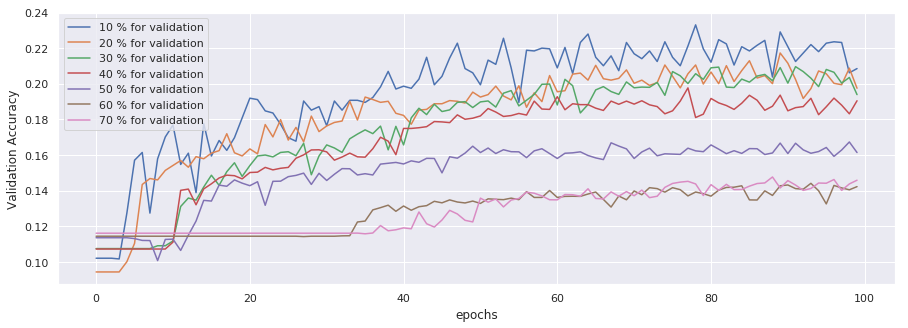

Showing accuracy


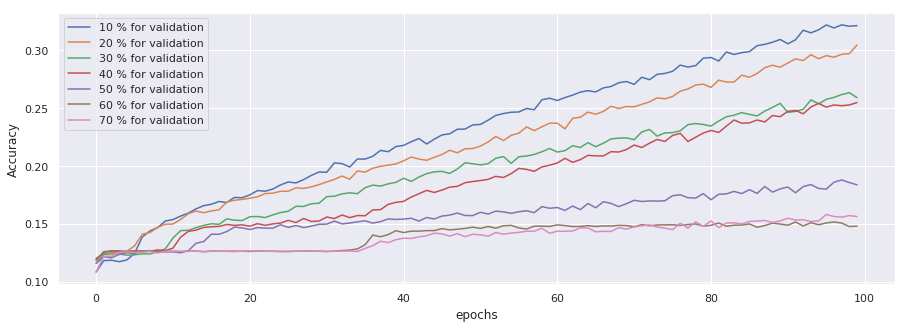

Using only chords, 100 epochs, lstm3
Final values
acc
0.9927296107621544
valacc
0.13313550934357649
loss
0.023922230613062003
valoss
7.8553825744417605

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 10, 12)            912       
_________________________________________________________________
bidirectional_48 (Bidirectio (None, 10, 256)           144384    
_________________________________________________________________
bidirectional_49 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dense_49 (Dense)             (None, 75)                19275     
Total params: 558,811
Trainable params: 558,811
Non-trainable params: 0
_________________________________________________________________
None


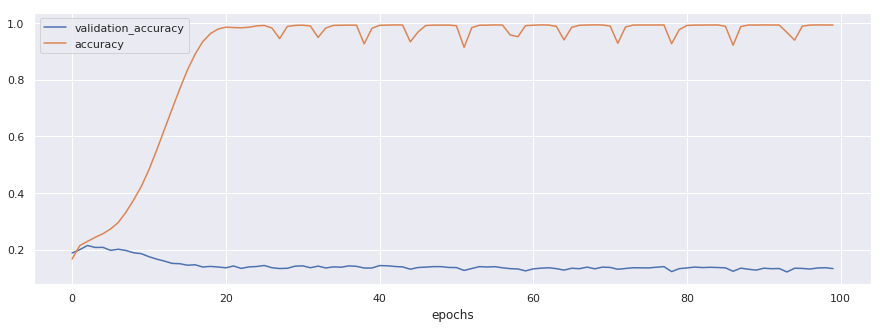

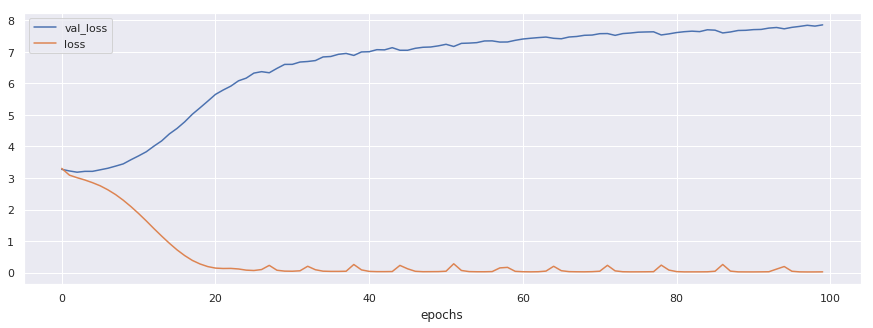

In [114]:
print("Using only chords, 100 epochs, lstm3")
disp_results(h3)

Using the time distributed version

Using all features, 300 epochs, lstm3
Final values
acc
0.9715614026705597
valacc
0.1372898120495733
loss
0.08930660636975903
valoss
8.895909447486039

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 12)            4068      
_________________________________________________________________
bidirectional_46 (Bidirectio (None, 10, 256)           144384    
_________________________________________________________________
bidirectional_47 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dense_47 (Dense)             (None, 75)                19275     
Total params: 561,967
Trainable params: 561,967
Non-trainable params: 0
_________________________________________________________________
None


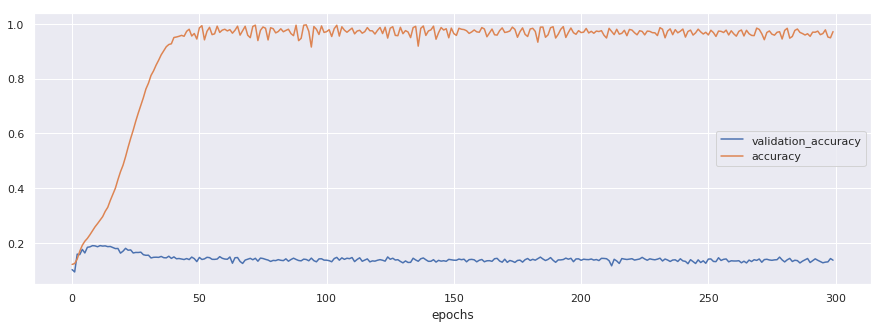

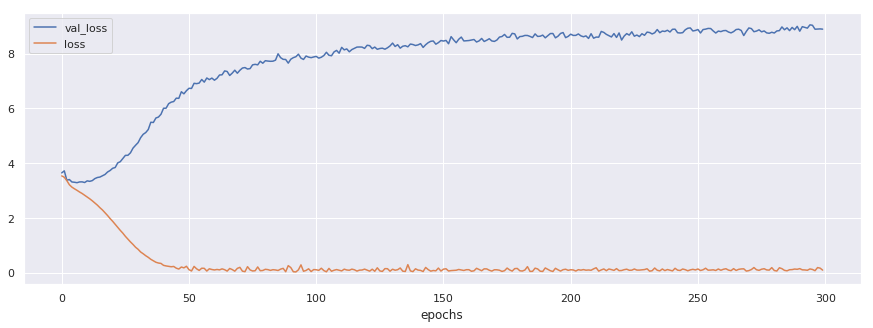

In [111]:
print("Using all features, 300 epochs, lstm3")
disp_results(h3)

### Training for 500 epochs

Using all features except chords, training for 500 epochs
Final values
acc
0.32301300757156176
valacc
0.17823936693982012
loss
2.4682189114069373
valoss
3.528936485060363

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_125 (LSTM)              (None, 10, 128)           200704    
_________________________________________________________________
dropout_80 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
bidirectional_42 (Bidirectio (None, 10, 128)           98816     
_________________________________________________________________
lstm_127 (LSTM)              (None, 32)                20608     
_________________________________________________________________
dropout_81 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 

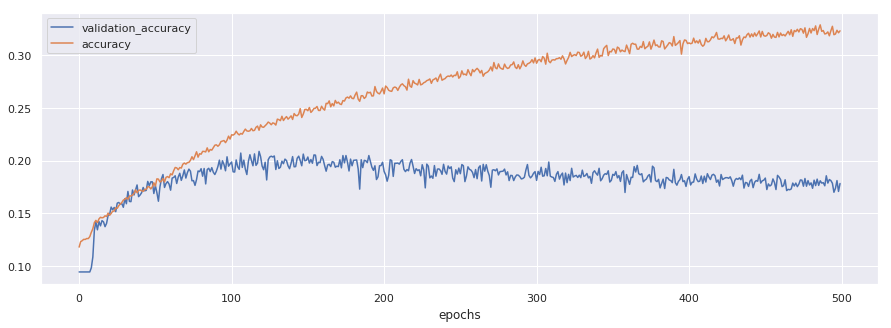

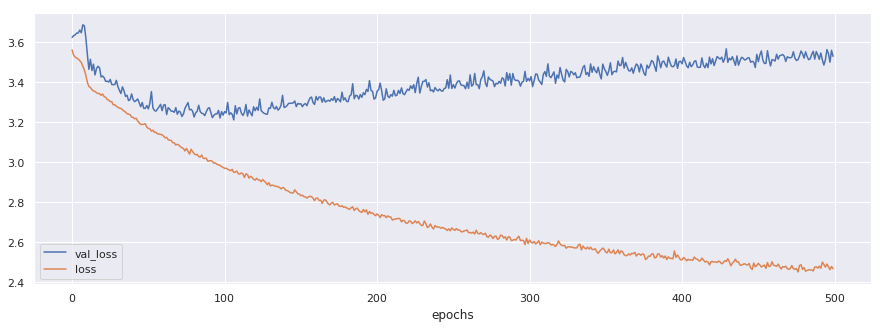

In [97]:
print("Using all features except chords, training for 500 epochs")
disp_results(h3)

### Primitive feature selection
What is best. Only chords, all features, all except chords?

Using only the chord feature
Final values
acc
0.4022948711460496
valacc
0.14025717109412278
loss
2.2165435983823487
valoss
4.454794151351431

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_113 (LSTM)              (None, 10, 128)           104448    
_________________________________________________________________
dropout_72 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
bidirectional_38 (Bidirectio (None, 10, 128)           98816     
_________________________________________________________________
lstm_115 (LSTM)              (None, 32)                20608     
_________________________________________________________________
dropout_73 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 75)                2475      


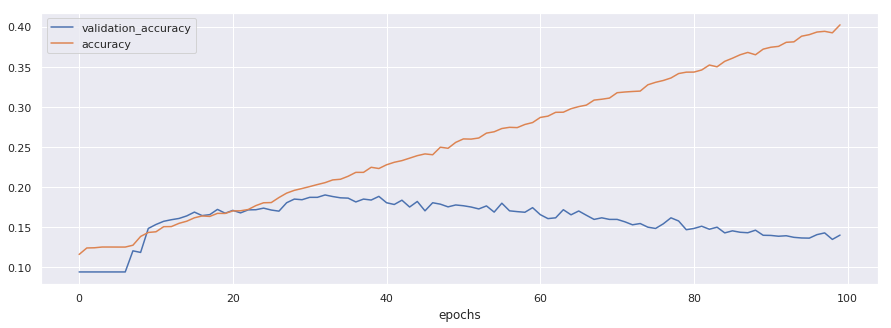

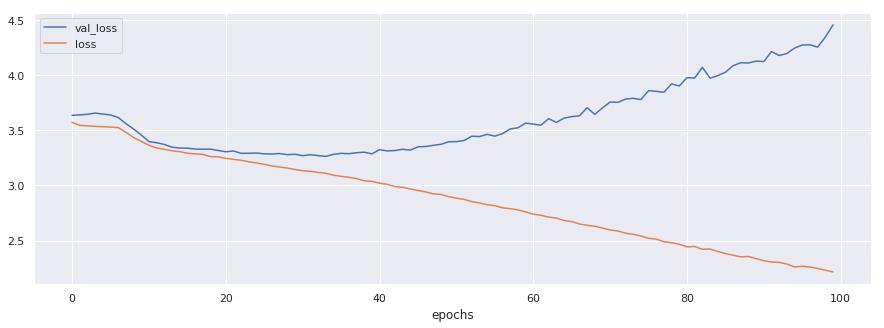

Using all features
Final values
acc
0.24091201345564095
valacc
0.19920870424142342
loss
2.9095368462197535
valoss
3.2357819291651544

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_116 (LSTM)              (None, 10, 128)           239104    
_________________________________________________________________
dropout_74 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
bidirectional_39 (Bidirectio (None, 10, 128)           98816     
_________________________________________________________________
lstm_118 (LSTM)              (None, 32)                20608     
_________________________________________________________________
dropout_75 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 75)                2475      
Total pa

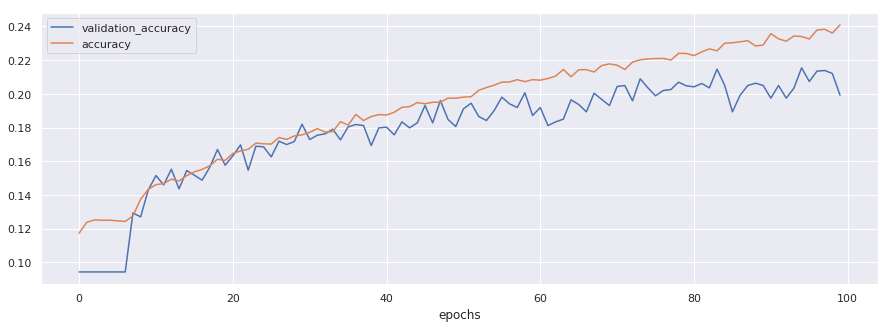

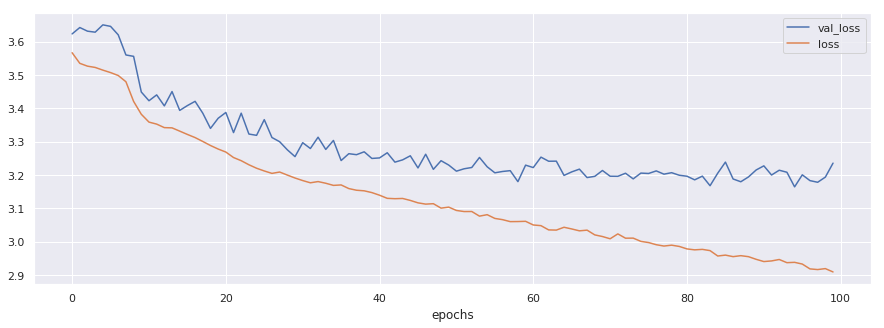

Using all features except chords
Final values
acc
0.2260250259494621
valacc
0.2025717111652612
loss
2.95196132054049
valoss
3.2145481655317054

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_119 (LSTM)              (None, 10, 128)           200704    
_________________________________________________________________
dropout_76 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
bidirectional_40 (Bidirectio (None, 10, 128)           98816     
_________________________________________________________________
lstm_121 (LSTM)              (None, 32)                20608     
_________________________________________________________________
dropout_77 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 75)                2475     

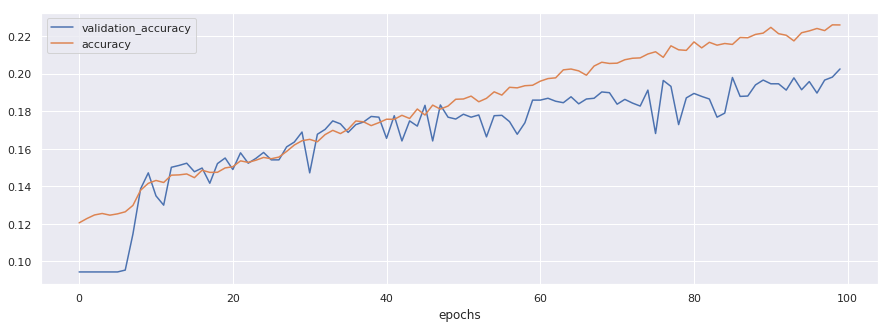

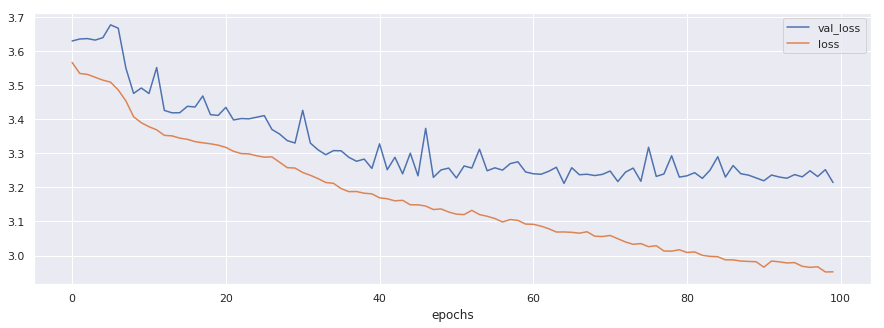

In [92]:
print("Using only the chord feature")
disp_results(h1)

print("Using all features")
disp_results(h2)

print("Using all features except chords")
disp_results(h3)


### Sequence lengths
Testing on sequence lenghts 5, 10, 20, 40, 80
Conclusions: Best with 10, marginal differences overall, significantly faster training with smaller sequences.

Final values
acc
0.18487645131149047
valacc
0.1522127405980036
loss
3.2899261492638048
valoss
3.598195571846422

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 160, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 160, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 160, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 160, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_____________________________

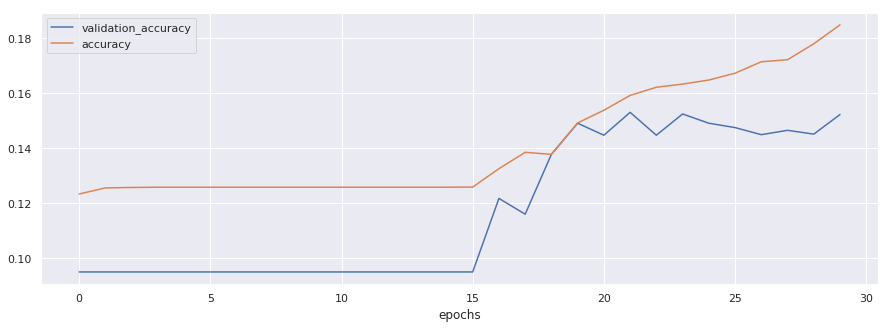

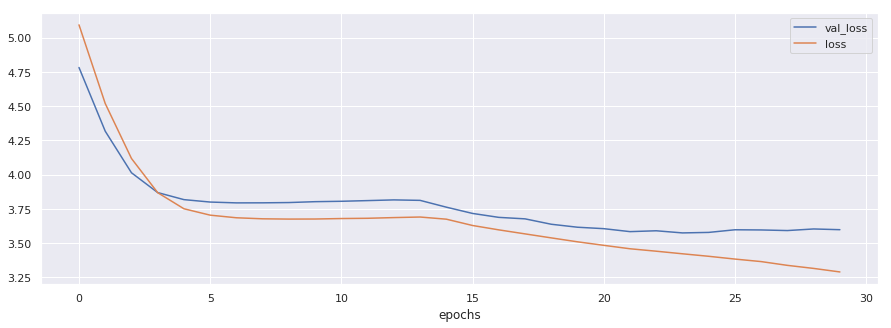

Final values
acc
0.21727047144922962
valacc
0.15839618893133928
loss
3.141557002150391
valoss
3.5978817542236254

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 160, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 160, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 160, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 160, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
____________________________

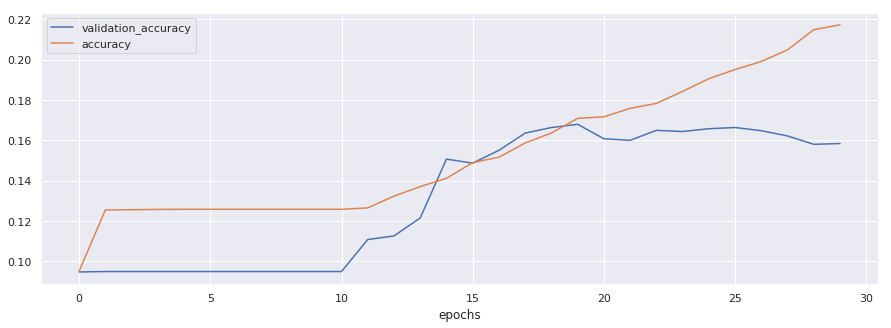

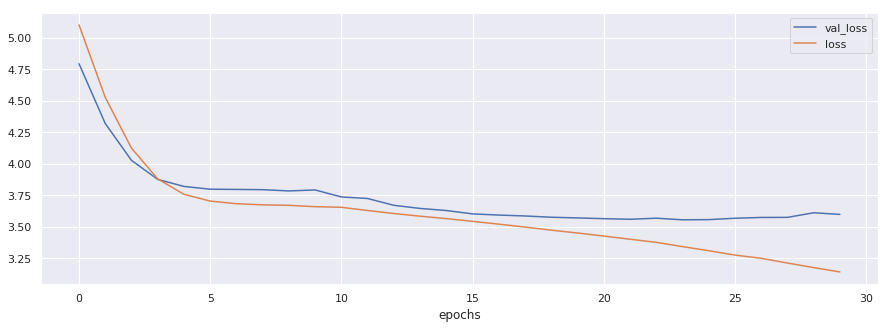

Final values
acc
0.16413464401260933
valacc
0.15031771248796802
loss
3.4155722475255472
valoss
3.5944106556102335

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 160, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 160, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 160, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 160, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
___________________________

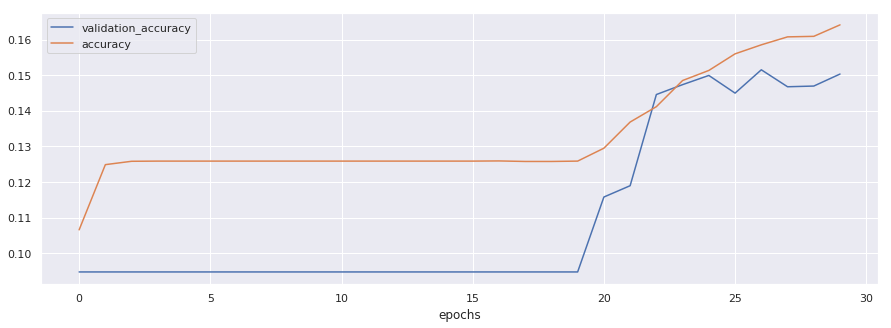

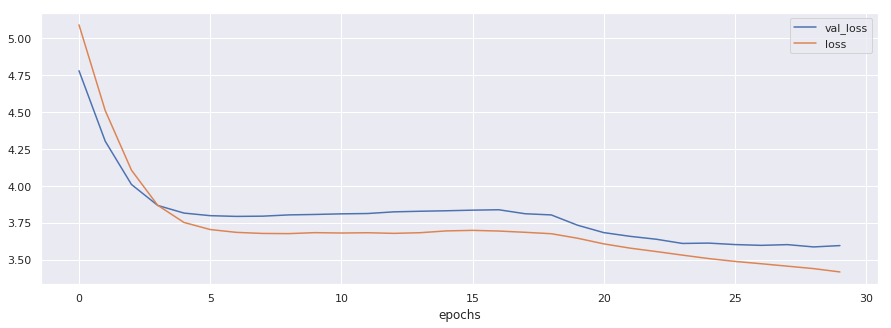

Final values
acc
0.18761800656312266
valacc
0.15441176470588236
loss
3.345946513408815
valoss
3.6128885901410173

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 160, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 160, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 160, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 160, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
____________________________

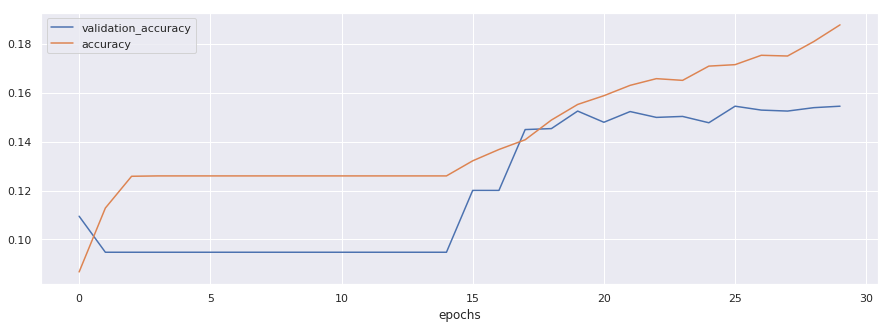

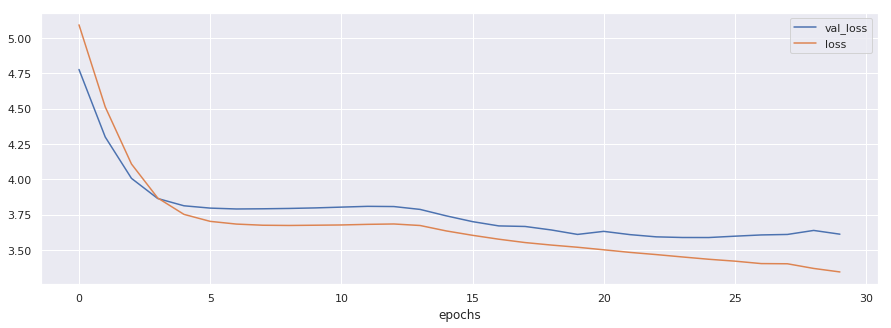

Final values
acc
0.14904946749235512
valacc
0.1429140127388535
loss
3.556054708363702
valoss
3.6760981447377783

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 160, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 160, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 160, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 160, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_____________________________

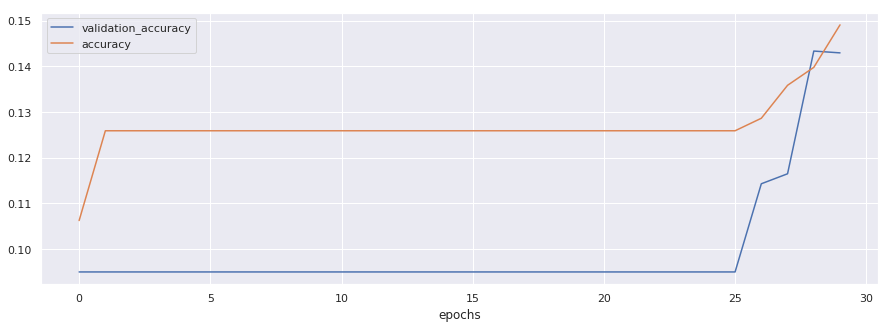

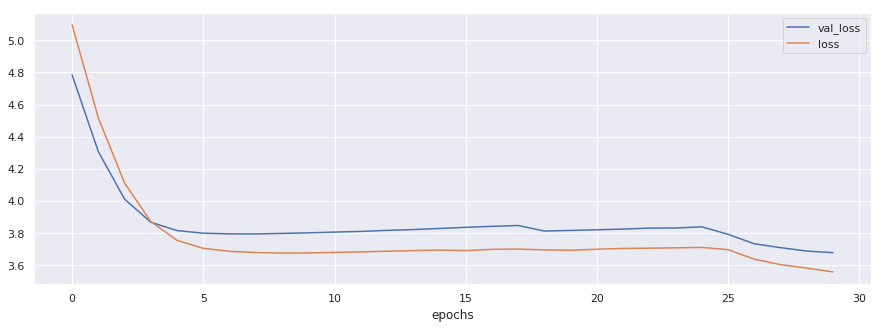

In [16]:
disp_results(h1)
disp_results(h2)
disp_results(h3)
disp_results(h4)
disp_results(h5)


In [28]:
#Save weights
h1.model.save("h1.hdf5")
h2.model.save("h2.hdf5")
h3.model.save("h3.hdf5")
h4.model.save("h4.hdf5")
h5.model.save("h5.hdf5")

### Training for 100 epochs using only the chords feature


Final values
acc
0.7754342432530879
valacc
0.11055974594571373
loss
0.8889608065602798
valoss
5.647335171178959

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 10, 256)           513024    
_________________________________________________________________
dropout_18 (Dropout)         (None, 10, 256)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 10, 512)           1574912   
_________________________________________________________________
dropout_19 (Dropout)         (None, 10, 512)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_____________________________

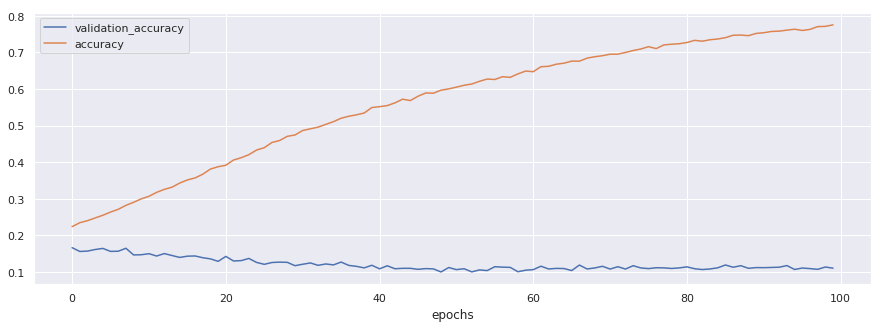

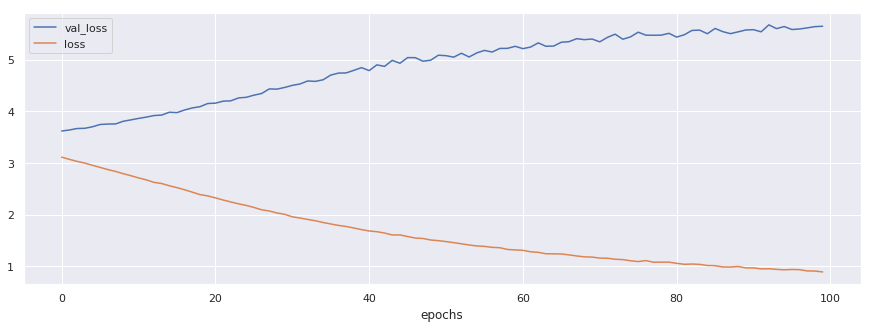

In [31]:
disp_results(h6)
h6.model.save("h6.hdf5")

### Training for 100 epochs using ALL features


Final values
acc
0.6240694788608598
valacc
0.1129416435034136
loss
1.402275422358927
valoss
5.05821556191257

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 256)           800768    
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 256)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 512)           1574912   
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 512)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
________________________________

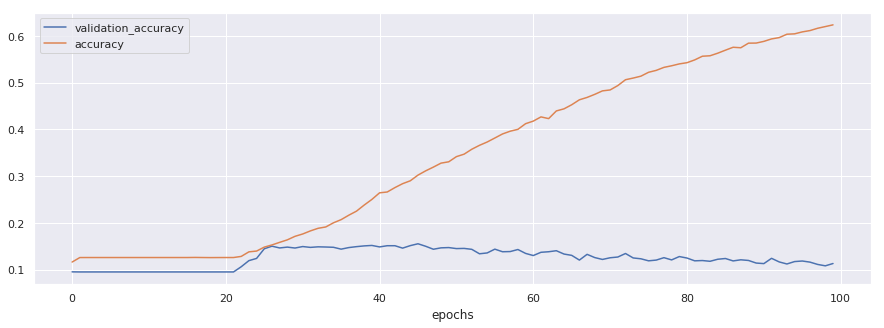

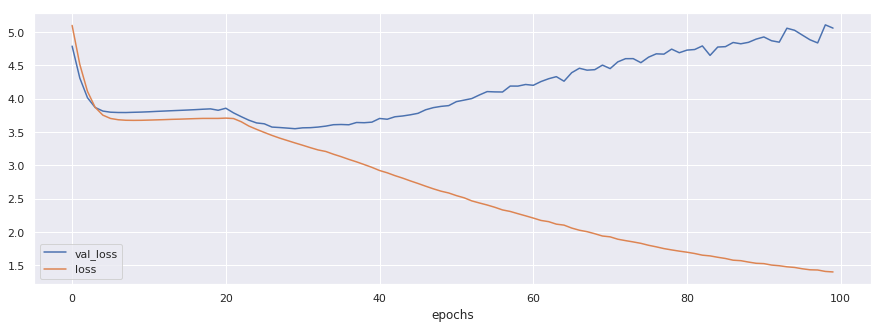

In [9]:
disp_results(h7)
h7.model.save("h7.hdf5")